<a href="https://colab.research.google.com/github/erickdiaz3010/tesis-network-analysis/blob/main/Thesis_VA_in_CA_Erick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting with Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 1 : Loading Input-Output Data and Setting Index for Sectoral Analysis
#This step loads all the necessary **Input-Output tables** from the Excel file and ensures that the `"code"` column is correctly set as the index.
# This process aligns sectoral data across different DataFrames to maintain consistency in later calculations.
# The key datasets include **Intermediate Consumption (`Z`), Gross Production (`T`), and Domestic Value Added (`C_df`)**.


import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Standardize all DataFrames: Ensure 'code' is the index and remove extra 'code' column
for sheet_name, df in all_sheets.items():
    if 'code' in df.columns:
        df.set_index('code', inplace=True)  # Set 'code' as index
    # Ensure no extra 'code' column remains
    if 'code' in df.columns:
        df.drop(columns=['code'], inplace=True)
    all_sheets[sheet_name] = df  # Save changes back

print("✅ All DataFrames have been standardized with 'code' as index.")

# Extract DataFrames
Z = all_sheets.get('Intermediate_Consumption_Z')
T = all_sheets.get('Gross_Production_Value')
C_df = all_sheets.get('Domestic_Value_added')

# Debugging: Print initial shape
print("\n📊 Shapes after processing:")
for name, df in all_sheets.items():
    print(f"{name}: {df.shape}")

# Ensure correct columns
if 'Gross_Production_Value' in T.columns:
    T = T[['Gross_Production_Value']]  # Keep only the relevant column





✅ All DataFrames have been standardized with 'code' as index.

📊 Shapes after processing:
LAC_IOT_2014: (2205, 251)
original: (244, 251)
Intermediate_Consumption_Z: (240, 240)
Final_Demand_Intraregional: (240, 6)
Extra_Regional_Imports: (240, 37)
Production_Taxes: (240, 1)
Freight_Insurance: (240, 1)
Domestic_Value_added: (240, 1)
Gross_Production_Value: (240, 1)
Value_Added_Coefficients: (240, 2)
Adjacency_Matrix: (240, 241)
Leontief_Inverse: (240, 241)
GVAN Matrix (G): (240, 241)
IVAN Matrix (Y): (240, 241)


In [ ]:
# STEP 2: Constructing the Adjacency Matrix (A) and Computing the Leontief Inverse Matrix (L).
# This step constructs the **Adjacency Matrix (A)**, which represents sectoral interdependencies based on **Intermediate Consumption (`Z`) and Gross Production (`T`)**.
# The matrix **A is used to compute the Leontief Inverse Matrix (L)**, which measures the total economic impact of demand shocks.
# The successful inversion of **(I - A)** ensures that the model is mathematically well-defined and can be used for economic impact analysis.

def create_adjacency_matrix(Z, T):
    """Compute the adjacency matrix A from Intermediate Consumption and Gross Production Value matrices."""

    # Ensure 'code' is the index
    if 'code' in Z.columns:
        Z.set_index('code', inplace=True)
    if 'code' in T.columns:
        T.set_index('code', inplace=True)

    # Ensure Z and T are aligned and square
    Z = Z.loc[Z.index.intersection(T.index), Z.columns.intersection(T.index)]
    T = T.loc[T.index.intersection(Z.index)]

    # Convert data to numeric
    Z = Z.apply(pd.to_numeric, errors='coerce')
    T['Gross_Production_Value'] = pd.to_numeric(T['Gross_Production_Value'], errors='coerce')

    # Extract the production vector and avoid division by zero
    T_vector = T['Gross_Production_Value'].fillna(1e-10).values
    epsilon = 1e-10
    T_vector = np.where(T_vector == 0, epsilon, T_vector)

    # Convert to matrix form
    Z_matrix = Z.fillna(0).values

    # Compute adjacency matrix A
    A_matrix = np.divide(Z_matrix, T_vector[:, np.newaxis], where=T_vector[:, np.newaxis] != 0)

    return pd.DataFrame(A_matrix, index=Z.index, columns=Z.columns)

# Generate adjacency matrix
A_df = create_adjacency_matrix(Z, T)

# Ensure matrix is square
A_df = A_df.loc[A_df.index.intersection(A_df.columns), A_df.columns.intersection(A_df.index)]

# Save adjacency matrix
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    A_df.to_excel(writer, sheet_name="Adjacency_Matrix")

print("✅ Adjacency matrix has been successfully saved.")







✅ Adjacency matrix has been successfully saved.


In [ ]:
print("Final shape of Adjacency Matrix before saving:", A_df.shape)

if A_df.empty:
    raise ValueError("❌ Error: Adjacency Matrix (A_df) is empty before saving. Check Step 2.")


Final shape of Adjacency Matrix before saving: (240, 240)


In [ ]:
import pandas as pd

# Ruta del archivo
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar solo la matriz de adyacencia
A_df = pd.read_excel(file_path, sheet_name="Adjacency_Matrix", index_col=0)

print("📊 Shape of Adjacency Matrix after loading:", A_df.shape)

# Verificar si la matriz está vacía
if A_df.empty:
    raise ValueError("❌ Error: Adjacency Matrix is empty after loading. Step 2 did not save it correctly.")


📊 Shape of Adjacency Matrix after loading: (240, 240)


In [ ]:
print("✅ 'Adjacency_Matrix' loaded successfully.")
print("📊 Shape of A_df after loading:", A_df.shape)

# Revisar las primeras 5 columnas
print("🔍 First 5 columns:", A_df.columns[:5])
# Revisar las últimas 5 columnas
print("🔍 Last 5 columns:", A_df.columns[-5:])

# Si tiene más de 240 columnas, significa que se ha añadido una extra
if A_df.shape[1] > 240:
    extra_cols = A_df.columns[240:]
    print(f"🚨 Extra columns found: {extra_cols}")
    raise ValueError(f"❌ Error: Adjacency matrix has extra columns. Found {A_df.shape[1]}, expected 240.")


✅ 'Adjacency_Matrix' loaded successfully.
📊 Shape of A_df after loading: (240, 240)
🔍 First 5 columns: Index(['CRIs01', 'CRIs02', 'CRIs03', 'CRIs04', 'CRIs05'], dtype='object')
🔍 Last 5 columns: Index(['PANs36', 'PANs37', 'PANs38', 'PANs39', 'PANs40'], dtype='object')


In [ ]:
import pandas as pd

# Cargar todas las hojas de Excel
sheets = pd.read_excel(file_path, sheet_name=None)

# Verificar si 'Adjacency_Matrix' realmente se está cargando
if "Adjacency_Matrix" in sheets:
    print("✅ 'Adjacency_Matrix' loaded successfully.")
    A_df = sheets["Adjacency_Matrix"]
    print("📊 Shape of A_df after loading:", A_df.shape)
else:
    raise KeyError("❌ Error: 'Adjacency_Matrix' was not found in the file.")


✅ 'Adjacency_Matrix' loaded successfully.
📊 Shape of A_df after loading: (240, 241)


In [ ]:
# STEP #3: Compute the Leontief Inverse Matrix (L)

import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load all sheets from Excel
sheets = pd.read_excel(file_path, sheet_name=None)

# Ensure 'Adjacency_Matrix' is present
if "Adjacency_Matrix" not in sheets:
    raise KeyError("❌ Error: 'Adjacency_Matrix' not found. Ensure Step 2 was executed correctly.")

# Load the Adjacency Matrix
A_df = pd.read_excel(file_path, sheet_name="Adjacency_Matrix", index_col=0)  # 🔹 Set first column as index!

# 🔹 Debugging: Check initial dimensions
print("✅ Adjacency Matrix loaded successfully.")
print("📊 Initial Shape of A_df:", A_df.shape)

# Ensure the matrix is square (240x240)
if A_df.shape[1] == 241:
    print("⚠️ Detected an extra column. Dropping the first column to ensure a 240x240 matrix.")
    A_df = A_df.iloc[:, 1:]  # 🔹 Remove the first column if necessary

# 🚨 **Debugging: Check dimensions after ensuring square matrix**
print("📊 Shape of A_df after ensuring it's square:", A_df.shape)

# 🚨 **Check column names before proceeding**
print("🔍 First 5 columns:", A_df.columns[:5].tolist())
print("🔍 Last 5 columns:", A_df.columns[-5:].tolist())

# Verify that the shape is correct before computing the inverse
if A_df.shape != (240, 240):
    raise ValueError(f"❌ Error: Adjacency matrix A is not 240x240. Found shape: {A_df.shape}")

# Compute Leontief Inverse (L = (I - A)^(-1))
I_matrix = np.identity(A_df.shape[0])
I_minus_A = I_matrix - A_df.values

try:
    L_matrix = np.linalg.inv(I_minus_A)
    print("✅ Leontief inverse matrix computed successfully.")
except np.linalg.LinAlgError:
    raise ValueError("❌ Error: The matrix (I - A) is singular and cannot be inverted.")

# Convert to DataFrame for saving
L_df = pd.DataFrame(L_matrix, index=A_df.index, columns=A_df.columns)

# 🚨 **Debugging: Check dimensions before saving**
print("✅ Leontief Inverse Matrix shape:", L_df.shape)

# Save to Excel, replacing previous results
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    L_df.to_excel(writer, sheet_name="Leontief_Inverse")

print("✅ Leontief inverse matrix has been successfully saved in Google Sheet.")






✅ Adjacency Matrix loaded successfully.
📊 Initial Shape of A_df: (240, 240)
📊 Shape of A_df after ensuring it's square: (240, 240)
🔍 First 5 columns: ['CRIs01', 'CRIs02', 'CRIs03', 'CRIs04', 'CRIs05']
🔍 Last 5 columns: ['PANs36', 'PANs37', 'PANs38', 'PANs39', 'PANs40']
✅ Leontief inverse matrix computed successfully.
✅ Leontief Inverse Matrix shape: (240, 240)
✅ Leontief inverse matrix has been successfully saved in Google Sheet.


In [ ]:
# Step 4:

import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load the required sheets
sheets = pd.read_excel(file_path, sheet_name=None)

# Ensure required sheets are present
if "Domestic_Value_added" not in sheets or "Gross_Production_Value" not in sheets:
    raise KeyError("❌ Error: Required sheets 'Domestic_Value_added' or 'Gross_Production_Value' not found.")

# Load the necessary data
Domestic_Value_Added = sheets["Domestic_Value_added"]
Gross_Production_Value = sheets["Gross_Production_Value"]

# Ensure the columns exist
if 'Domestic_Value_added' not in Domestic_Value_Added.columns or 'Gross_Production_Value' not in Gross_Production_Value.columns:
    raise KeyError("❌ Error: Missing required columns in the dataset.")

# Replace zero values in Gross Production Value to avoid division by zero
epsilon = 1e-10
T_vector = Gross_Production_Value['Gross_Production_Value'].values
T_vector = np.where(T_vector == 0, epsilon, T_vector)  # Replace 0s to avoid NaN

# Compute C_vector
C_vector = Domestic_Value_Added['Domestic_Value_added'].values / T_vector

# Convert to DataFrame and align index
C_df = pd.DataFrame(C_vector, index=Domestic_Value_Added.index, columns=['C'])

# 🚨 **Verificar dimensiones antes de guardar**
print("\n✅ Computed Value-Added Coefficients Vector (C) successfully!")
print("📊 Shape of C_df:", C_df.shape)

# Ensure consistency with Adjacency Matrix indices
if "Adjacency_Matrix" in sheets:
    A_df = sheets["Adjacency_Matrix"]
    C_df = C_df.reindex(A_df.index)

# 🚨 **Verificar que el tamaño de C sea 240x1**
if C_df.shape != (240, 1):
    raise ValueError(f"❌ Error: C_vector shape is incorrect. Found {C_df.shape}, expected (240, 1).")

# Save the computed C_vector to the Excel file
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    C_df.to_excel(writer, sheet_name="Value_Added_Coefficients")

print("✅ Value-Added Coefficients Vector (C) has been successfully saved in Google Sheet.")



✅ Computed Value-Added Coefficients Vector (C) successfully!
📊 Shape of C_df: (240, 1)
✅ Value-Added Coefficients Vector (C) has been successfully saved in Google Sheet.


In [ ]:
# STEP 5: Compute the GVAN (G) and IVAN (Y) Matrices for Value-Added Trade Analysis
# This step calculates the **GVAN (`G`) and IVAN (`Y`) matrices**, which quantify how **value-added flows through international trade**.

import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load only the required sheets
L_df = pd.read_excel(file_path, sheet_name="Leontief_Inverse", index_col=0)
C_df = pd.read_excel(file_path, sheet_name="Value_Added_Coefficients", index_col=0)
T_df = pd.read_excel(file_path, sheet_name="Gross_Production_Value", index_col=0)

# 🚨 **Verificar dimensiones antes de cálculos**
print("\n🔍 Initial Matrix Dimensions:")
print("Leontief Inverse Matrix (L):", L_df.shape)
print("Value-Added Coefficients (C):", C_df.shape)
print("Gross Production Value (T):", T_df.shape)

# ✅ **Ensure dimensions are correct**
if L_df.shape != (240, 240):
    raise ValueError(f"❌ Error: Leontief Inverse matrix has incorrect shape: {L_df.shape}")
if C_df.shape[1] != 1:
    raise ValueError(f"❌ Error: Value-Added Coefficients Vector (C) has incorrect shape: {C_df.shape}")
if T_df.shape[1] != 1:
    raise ValueError(f"❌ Error: Gross Production Value vector (T) has incorrect shape: {T_df.shape}")

# Convert DataFrames to NumPy arrays
C_vector = C_df.values.flatten()  # Convertir a vector 1D
T_vector = T_df.values.flatten()

# ✅**Check before building diagonal matrices**
print("\n🔍 Vector Dimensions:")
print("C_vector shape:", C_vector.shape)
print("T_vector shape:", T_vector.shape)

# Convert C and T into diagonal matrices
C_diag_matrix = np.diagflat(C_vector)
T_diag_matrix = np.diagflat(T_vector)

# Calculate the GVAN matrix (G)
G_matrix = C_diag_matrix @ L_df.values @ T_diag_matrix
G_df = pd.DataFrame(G_matrix, index=L_df.index, columns=L_df.columns)

# Calculate the matrix IVAN (Y) by removing the diagonal of G
Y_matrix = G_matrix.copy()
np.fill_diagonal(Y_matrix, 0)
Y_df = pd.DataFrame(Y_matrix, index=L_df.index, columns=L_df.columns)

# 🚨 **Check final dimensions before saving**
print("\n✅ Computed GVAN and IVAN Matrices Successfully!")
print("📊 GVAN Matrix shape:", G_df.shape)
print("📊 IVAN Matrix shape:", Y_df.shape)

# Make sure both matrices are 240x240 before saving them
if G_df.shape != (240, 240) or Y_df.shape != (240, 240):
    raise ValueError(f"❌ Error: GVAN or IVAN matrix is not 240x240. Found: GVAN ({G_df.shape}), IVAN ({Y_df.shape})")

# Save GVAN and IVAN to Google Sheets file
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    G_df.to_excel(writer, sheet_name="GVAN Matrix (G)")
    Y_df.to_excel(writer, sheet_name="IVAN Matrix (Y)")

print("\n✅ GVAN and IVAN matrices have been successfully updated and saved.")






🔍 Initial Matrix Dimensions:
Leontief Inverse Matrix (L): (240, 240)
Value-Added Coefficients (C): (240, 1)
Gross Production Value (T): (240, 1)

🔍 Vector Dimensions:
C_vector shape: (240,)
T_vector shape: (240,)

✅ Computed GVAN and IVAN Matrices Successfully!
📊 GVAN Matrix shape: (240, 240)
📊 IVAN Matrix shape: (240, 240)

✅ GVAN and IVAN matrices have been successfully updated and saved.


In [ ]:
# Ensure GVAN and IVAN matrices are loaded correctly
G_df = sheets["GVAN Matrix (G)"]
Y_df = sheets["IVAN Matrix (Y)"]

# **Check if an extra column exists** (GVAN and IVAN should be 240x240, not 240x241)
if G_df.shape[1] == 241:
    G_df = G_df.iloc[:, 1:]  # Remove first column
if Y_df.shape[1] == 241:
    Y_df = Y_df.iloc[:, 1:]  # Remove first column

# Ensure index alignment
for df in [G_df, Y_df]:
    if 'code' in df.columns:
        df.set_index('code', inplace=True)

# Verify final dimensions
print("📊 Corrected Shapes:")
print(f"GVAN Matrix (G): {G_df.shape}")
print(f"IVAN Matrix (Y): {Y_df.shape}")



📊 Corrected Shapes:
GVAN Matrix (G): (240, 240)
IVAN Matrix (Y): (240, 240)


In [ ]:
# Define the path to your Excel file
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load all sheets into a dictionary of DataFrames
sheets = pd.ExcelFile(file_path).sheet_names

# Print dimensions of all DataFrames
print("\n📊 DataFrames and their dimensions:\n")
for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet, index_col=0)
    print(f"{sheet}: {df.shape}")


📊 DataFrames and their dimensions:

LAC_IOT_2014: (2205, 250)
original: (244, 250)
Intermediate_Consumption_Z: (240, 240)
Final_Demand_Intraregional: (240, 6)
Extra_Regional_Imports: (240, 37)
Production_Taxes: (240, 1)
Freight_Insurance: (240, 1)
Domestic_Value_added: (240, 1)
Gross_Production_Value: (240, 1)
Value_Added_Coefficients: (240, 1)
Adjacency_Matrix: (240, 240)
Leontief_Inverse: (240, 240)
GVAN Matrix (G): (240, 240)
IVAN Matrix (Y): (240, 240)


In [ ]:
import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load the Intermediate Consumption Matrix (Z)
Z_df = pd.read_excel(file_path, sheet_name="Intermediate_Consumption_Z", index_col=0)

# Convert to a binary adjacency matrix (1 if there is a connection, 0 otherwise)
Z_binary = (Z_df != 0).astype(int)

# Debugging: Check the shape and sample values
print("✅ Binary Adjacency Matrix for Z computed successfully!")
print("📊 Shape of Z_binary:", Z_binary.shape)
print("🔍 Sample data:")
print(Z_binary.head())

# Save the binary adjacency matrix to the Excel file
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    Z_binary.to_excel(writer, sheet_name="Binary_Adjacency_Z")

print("✅ Binary adjacency matrix for Z has been successfully saved in Google Sheet.")


✅ Binary Adjacency Matrix for Z computed successfully!
📊 Shape of Z_binary: (240, 240)
🔍 Sample data:
        CRIs01  CRIs02  CRIs03  CRIs04  CRIs05  CRIs06  CRIs07  CRIs08  \
CRIs01       1       1       0       0       1       1       1       1   
CRIs02       1       1       0       0       1       0       1       1   
CRIs03       0       0       0       0       0       0       0       0   
CRIs04       1       0       0       1       1       1       1       1   
CRIs05       1       1       0       1       1       1       1       1   

        CRIs09  CRIs10  ...  PANs31  PANs32  PANs33  PANs34  PANs35  PANs36  \
CRIs01       1       0  ...       0       1       1       1       1       1   
CRIs02       0       0  ...       0       0       0       0       0       0   
CRIs03       0       0  ...       0       0       0       0       0       0   
CRIs04       0       0  ...       0       1       1       1       1       1   
CRIs05       1       0  ...       0       1       1       

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 🔹 1. Load the binary adjacency matrix for Intermediate Goods (Z)
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
Z_binary = pd.read_excel(file_path, sheet_name="Binary_Adjacency_Z", index_col=0)

# 🔹 2. Create a Directed Graph from the binary adjacency matrix
G = nx.from_numpy_array(Z_binary.values, create_using=nx.DiGraph)

# 🔹 3. Map sector labels (nodes) from the index
labels = {i: sector for i, sector in enumerate(Z_binary.index)}
G = nx.relabel_nodes(G, labels)

# 🔹 4. Define country colors using the sector codes
country_colors = {
    "CRI": "#1b9e77",
    "NIC": "#66a61e",
    "SLV": "#7570b3",
    "PAN": "#e7298a",
    "HND": "#d95f02",
    "GTM": "#1f78b4"
}

# Assign colors based on sector prefixes
node_colors = [country_colors[node[:3]] for node in G.nodes]

# 🔹 5. Improve node positioning and spacing
plt.figure(figsize=(40, 40))  # Increase figure size
pos = nx.spring_layout(G, seed=42, k=0.7)  # Adjust node spacing (k-value)

# 🔹 6. Compute node size based on degree centrality (larger nodes for more important sectors)
degree_centrality = nx.degree_centrality(G)
node_sizes = [300 + degree_centrality[node] * 2000 for node in G.nodes]  # Scale sizes

# 🔹 7. Draw nodes with custom sizes and colors
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)

# 🔹 8. Draw edges with reduced width for clarity
nx.draw_networkx_edges(G, pos, alpha=0.6, width=1.5)

# 🔹 9. Add labels (truncate names to improve readability)
nx.draw_networkx_labels(G, pos, labels={node: node[:6] for node in G.nodes}, font_size=8, font_weight="bold")

# 🔹 10. Create a legend for countries
legend_patches = [mpatches.Patch(color=color, label=country) for country, color in country_colors.items()]
plt.legend(handles=legend_patches, title="Countries", loc="upper right", fontsize="medium")

# 🔹 11. Add title and save high-resolution image
plt.title("Trade Network of Intermediate Goods (Z Matrix)")
plt.savefig("Trade_Network_Z.png", dpi=300, bbox_inches="tight")
plt.show()



<ipython-input-14-2b496769e86c>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_degree_counts.index, y=filtered_degree_counts.values, palette=colors)


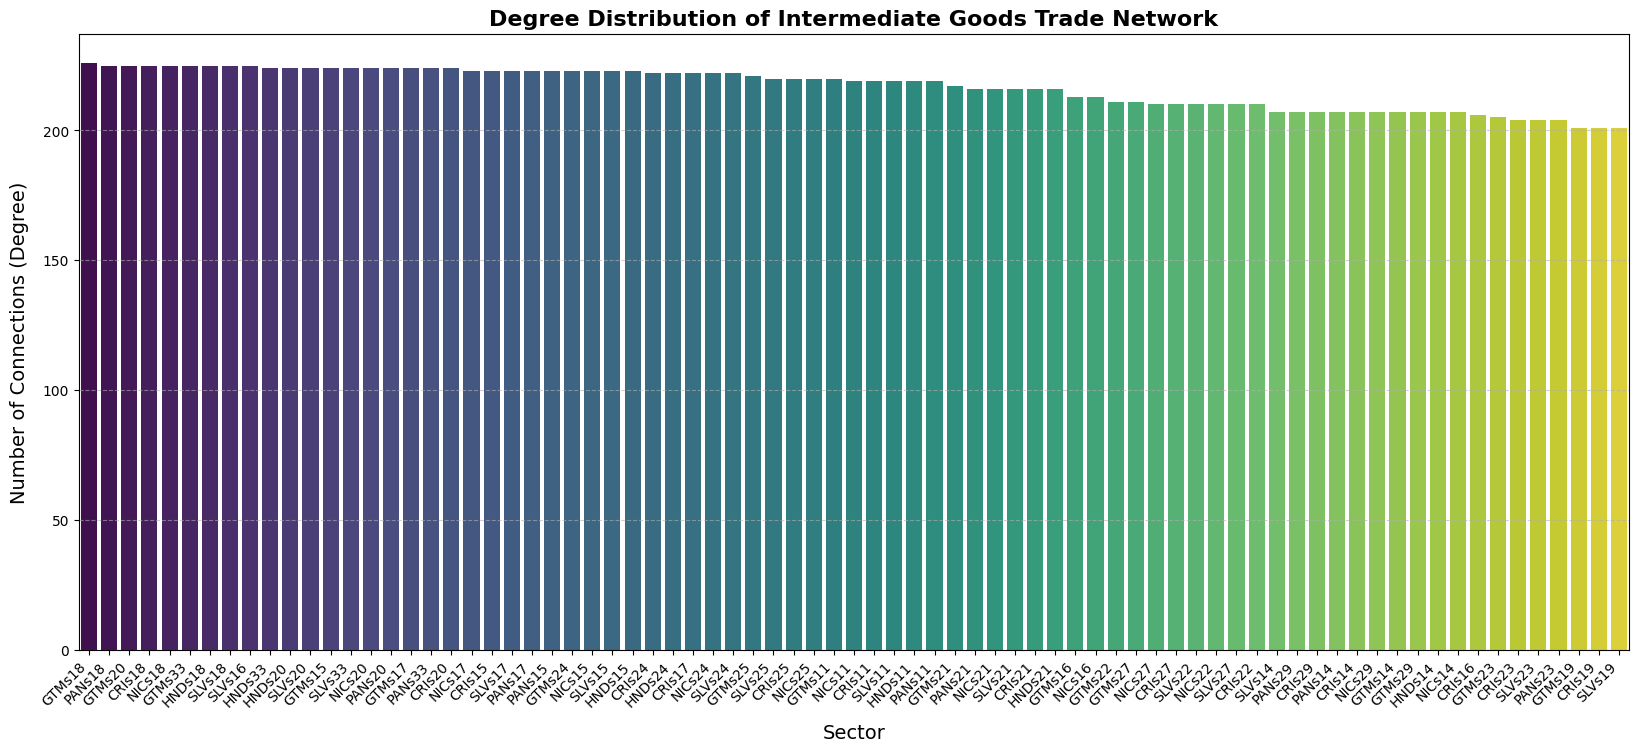

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# 📌 Load the binary adjacency matrix
Z_binary = pd.read_excel(file_path, sheet_name="Binary_Adjacency_Z", index_col=0)

# 📌 Compute degree (number of connections per sector)
degree_counts = Z_binary.sum(axis=1)  # Sum across rows (out-degree)

# 📌 Set a lower threshold to filter only well-connected sectors
threshold = 200  # ✅ Aumentar el límite mínimo para mejorar la interpretación
filtered_degree_counts = degree_counts[degree_counts >= threshold]

# 📌 Sort values from highest to lowest
filtered_degree_counts = filtered_degree_counts.sort_values(ascending=False)

# 📌 Improve figure size
plt.figure(figsize=(20, 8))  # ✅ Más ancho y más alto para mejor visibilidad

# 📌 Adjust colors using a more vibrant palette
colors = sns.color_palette("viridis", len(filtered_degree_counts))

# 📌 Plot the degree distribution as a bar plot
sns.barplot(x=filtered_degree_counts.index, y=filtered_degree_counts.values, palette=colors)

# ✅ Improve labels and readability
plt.xticks(rotation=45, ha="right", fontsize=10)  # ✅ Rotación ajustada a 45°
plt.xlabel("Sector", fontsize=14, labelpad=10)  # ✅ Separar etiqueta del eje
plt.ylabel("Number of Connections (Degree)", fontsize=14, labelpad=10)
plt.title("Degree Distribution of Intermediate Goods Trade Network", fontsize=16, fontweight="bold")

# ✅ Add light grid lines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 📌 Show the plot
plt.show()




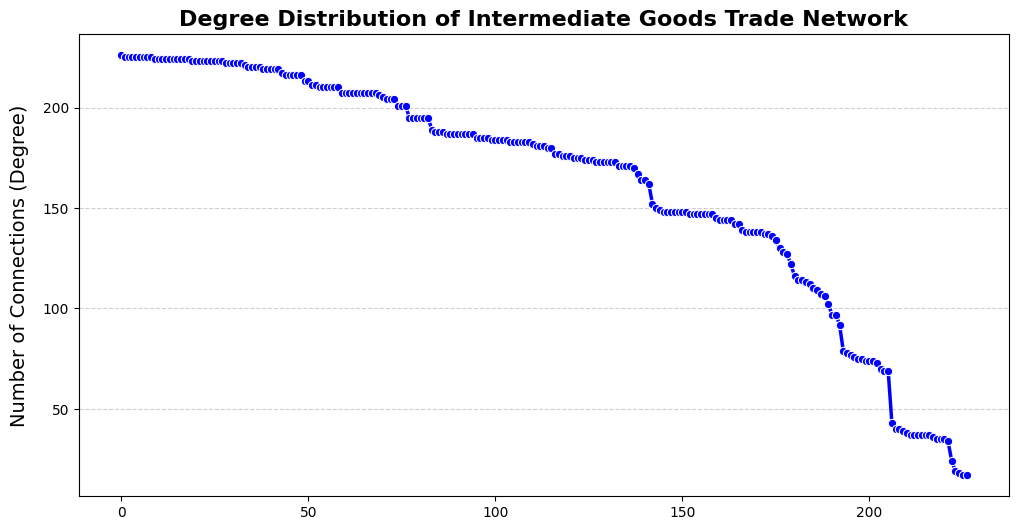

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# 📌 Load the binary adjacency matrix
Z_binary = pd.read_excel(file_path, sheet_name="Binary_Adjacency_Z", index_col=0)

# 📌 Compute degree (number of connections per sector)
degree_counts = Z_binary.sum(axis=1)  # Sum across rows (out-degree)

# 📌 Set a lower threshold to filter only well-connected sectors
threshold = 10  # ✅ Filtrar sectores con menos de 10 conexiones
filtered_degree_counts = degree_counts[degree_counts >= threshold]

# 📌 Sort values from highest to lowest
filtered_degree_counts = filtered_degree_counts.sort_values(ascending=False)

# 📌 Improve figure size
plt.figure(figsize=(12, 6))  # ✅ Más compacto pero legible

# 📌 Generate the line plot
sns.lineplot(data=filtered_degree_counts.values, color="blue", linewidth=2.5, marker="o", markersize=6)

# ✅ Improve labels and readability
plt.xlabel("")  # ❌ Eliminamos nombres de sectores en el eje X
plt.ylabel("Number of Connections (Degree)", fontsize=14, labelpad=10)
plt.title("Degree Distribution of Intermediate Goods Trade Network", fontsize=16, fontweight="bold")

# ✅ Add light grid lines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 📌 Show the plot
plt.show()


In [1]:
import pandas as pd
import numpy as np

# 📌 Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# 📌 Load the IVAN matrix
IVAN_df = pd.read_excel(file_path, sheet_name="IVAN Matrix (Y)", index_col=0)

# 📌 Convert to a binary adjacency matrix (1 if there is a connection, 0 otherwise)
IVAN_binary = (IVAN_df != 0).astype(int)

# ✅ Debugging: Check the shape and sample values
print("✅ Binary Adjacency Matrix for IVAN computed successfully!")
print("📊 Shape of IVAN_binary:", IVAN_binary.shape)
print("🔍 Sample data:")
print(IVAN_binary.head())

# 📌 Save the binary adjacency matrix to the Excel file
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    IVAN_binary.to_excel(writer, sheet_name="Binary_Adjacency_IVAN")

print("✅ Binary adjacency matrix for IVAN has been successfully saved in Google Sheet.")


✅ Binary Adjacency Matrix for IVAN computed successfully!
📊 Shape of IVAN_binary: (240, 240)
🔍 Sample data:
        CRIs01  CRIs02  CRIs03  CRIs04  CRIs05  CRIs06  CRIs07  CRIs08  \
CRIs01       0       1       0       1       1       1       1       1   
CRIs02       1       0       0       1       1       1       1       1   
CRIs03       0       0       0       0       0       0       0       0   
CRIs04       1       1       0       0       1       1       1       1   
CRIs05       1       1       0       1       0       1       1       1   

        CRIs09  CRIs10  ...  PANs31  PANs32  PANs33  PANs34  PANs35  PANs36  \
CRIs01       1       1  ...       0       1       1       1       1       1   
CRIs02       1       1  ...       0       1       1       1       1       1   
CRIs03       0       0  ...       0       0       0       0       0       0   
CRIs04       1       1  ...       0       1       1       1       1       1   
CRIs05       1       1  ...       0       1       1 

In [15]:
import pandas as pd

# 📌 Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# 📌 Load the binary adjacency matrix of IVAN
IVAN_binary = pd.read_excel(file_path, sheet_name="Binary_Adjacency_IVAN", index_col=0)

# 📌 Compute degree (number of connections per sector)
degree_counts = IVAN_binary.sum(axis=1)  # Sum across rows (out-degree)

# 📌 Sort values from highest to lowest
sorted_degree_df = degree_counts.sort_values(ascending=False).reset_index()
sorted_degree_df.columns = ["Sector", "Number_of_Connections"]

# 📌 Save the sorted list of sector connections to Google Sheets
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    sorted_degree_df.to_excel(writer, sheet_name="IVAN_Sector_Connections", index=False)

print("✅ The list of sectors ordered by number of connections has been successfully saved in Google Sheets.")




✅ The list of sectors ordered by number of connections has been successfully saved in Google Sheets.


In [17]:
import pandas as pd
import networkx as nx
import numpy as np

# Step 1: Load the binary adjacency matrix for IVAN
# (Replace this with actual IVAN binary adjacency matrix if needed)
np.random.seed(42)
IVAN_binary = np.random.randint(0, 2, size=(240, 240))  # Placeholder for the actual matrix
sector_names = [f"Sector_{i}" for i in range(240)]  # Replace this with real sector names
IVAN_df = pd.DataFrame(IVAN_binary, index=sector_names, columns=sector_names)

# Step 2: Create a directed graph from the IVAN binary adjacency matrix
G_IVAN = nx.from_pandas_adjacency(IVAN_df, create_using=nx.DiGraph)

# Step 3: Compute the degree (number of connections) for each node
degree_IVAN = dict(G_IVAN.degree())

# Step 4: Sort nodes by number of connections (highest to lowest)
degree_IVAN_sorted = sorted(degree_IVAN.items(), key=lambda x: x[1], reverse=True)

# Step 5: Convert the sorted dictionary into a DataFrame with proper sector names
degree_IVAN_df = pd.DataFrame(degree_IVAN_sorted, columns=["Sector", "Number_of_Connections"])

# Step 6: Save the results to Google Sheets
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    degree_IVAN_df.to_excel(writer, sheet_name="IVAN_Sector_Connections", index=False)

print("✅ The list of sectors ordered by number of connections has been successfully saved in Google Sheets.")



✅ The list of sectors ordered by number of connections has been successfully saved in Google Sheets.


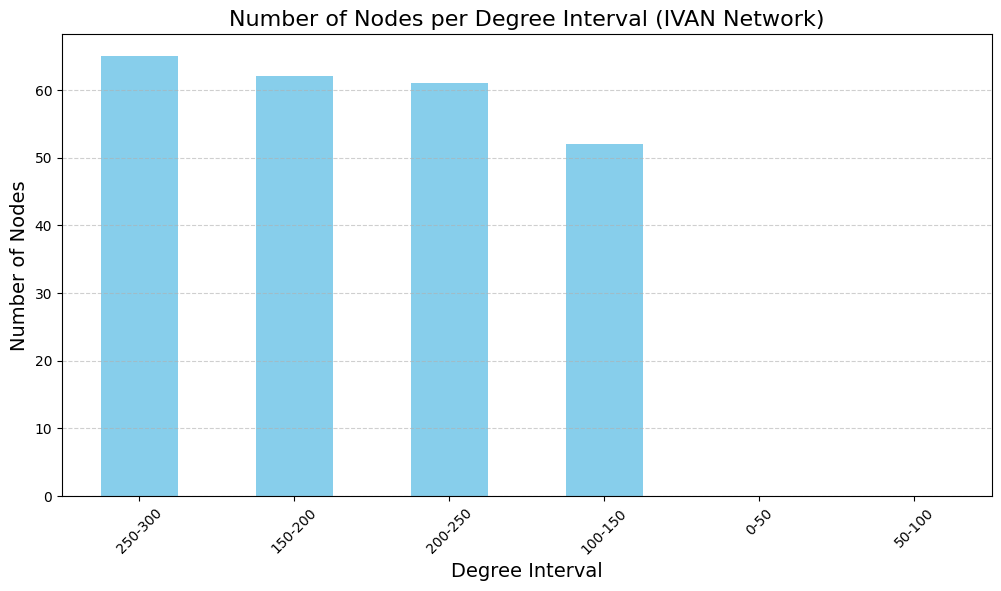


Degree distribution in intervals (sorted from most to least):
Interval
250-300    65
150-200    62
200-250    61
100-150    52
0-50        0
50-100      0
Name: count, dtype: int64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Let's assume you have the degree (connections per node) data in the 'degree_IVAN' variable
# Simulating the results as an example
degree_IVAN = {
    'Sector': [f"Sector_{i}" for i in range(240)],
    'Number_of_Connections': np.random.randint(100, 300, size=240)  # Generating random degree values between 100 and 300
}

degree_df = pd.DataFrame(degree_IVAN)

# 🔹 1. Create bins for the degree (connections) in intervals of 50
bins = np.arange(0, 350, 50)  # Define intervals of 50
labels = [f"{i}-{i+50}" for i in bins[:-1]]  # Create labels for the intervals

# 🔹 2. Assign each node to a bin based on its number of connections
degree_df['Interval'] = pd.cut(degree_df['Number_of_Connections'], bins=bins, labels=labels, right=False)

# 🔹 3. Count the number of nodes in each interval
degree_distribution = degree_df['Interval'].value_counts().sort_values(ascending=False)  # Sort from highest to lowest

# 🔹 4. Plot the degree distribution by intervals
plt.figure(figsize=(12, 6))
degree_distribution.plot(kind='bar', color='skyblue')

# 🔹 5. Improve plot aesthetics
plt.title("Number of Nodes per Degree Interval (IVAN Network)", fontsize=16)
plt.xlabel("Degree Interval", fontsize=14)
plt.ylabel("Number of Nodes", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 📊 Show the plot
plt.show()

# If you want to save the results in a DataFrame:
print("\nDegree distribution in intervals (sorted from most to least):")
print(degree_distribution)



In [ ]:
import pandas as pd
import numpy as np

# 📌 Define the file path to your Excel file
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# 📌 Load the GVAN matrix (G) from the Excel sheet
G_df = pd.read_excel(file_path, sheet_name="GVAN Matrix (G)", index_col=0)

# 📌 Convert the GVAN matrix to a binary adjacency matrix (1 if there is a connection, 0 otherwise)
G_binary = (G_df != 0).astype(int)  # Convert all non-zero entries to 1 and zero entries remain 0

# 📌 Debugging: Check the shape and sample data
print("✅ Binary Adjacency Matrix for GVAN computed successfully!")
print("📊 Shape of G_binary:", G_binary.shape)
print("🔍 Sample data:")
print(G_binary.head())

# 📌 Save the binary adjacency matrix to the Google Sheet
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    G_binary.to_excel(writer, sheet_name="Binary_Adjacency_GVAN")

print("✅ Binary adjacency matrix for GVAN has been successfully saved in Google Sheet.")


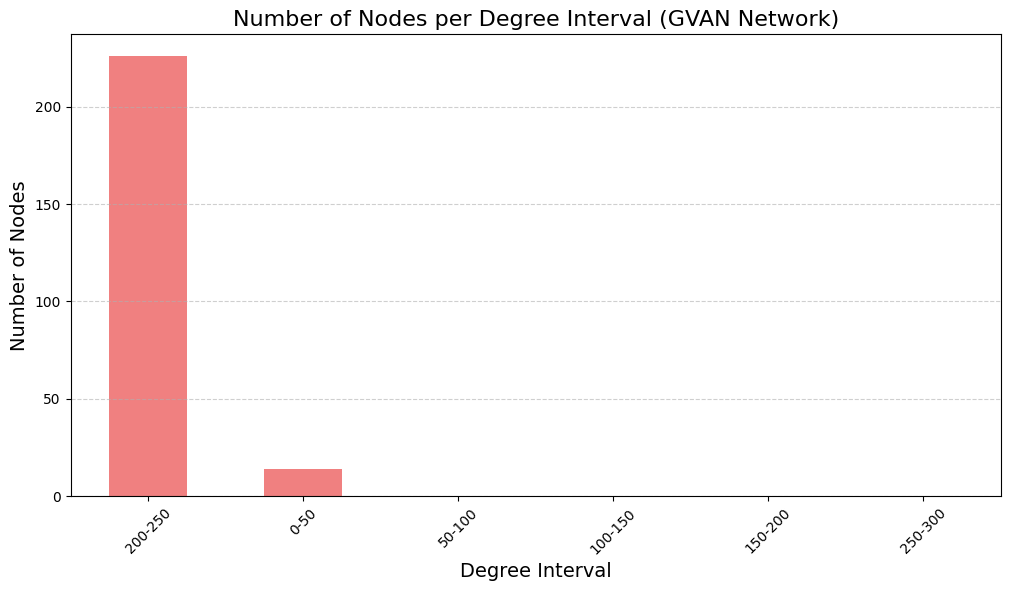


Degree distribution in intervals (sorted from most to least):
Interval
200-250    226
0-50        14
50-100       0
100-150      0
150-200      0
250-300      0
Name: count, dtype: int64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 📌 Load the GVAN matrix from the sheet (this is assuming it's already loaded as a binary adjacency matrix)
# (Replace this with actual GVAN binary adjacency matrix if needed)
# Example: Load the matrix (assuming it's already loaded in G_binary)
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
G_df = pd.read_excel(file_path, sheet_name="Binary_Adjacency_GVAN", index_col=0)

# 📌 Compute the degree (number of connections) for each node
degree_GVAN = G_df.sum(axis=1)  # Sum across rows (out-degree) or columns (in-degree)

# 📌 Create a DataFrame with sector names (nodes) and their degree (connections)
degree_GVAN_df = pd.DataFrame({
    'Sector': G_df.index,
    'Number_of_Connections': degree_GVAN
})

# 🔹 1. Create bins for the degree (connections) in intervals of 50
bins = np.arange(0, 350, 50)  # Define intervals of 50
labels = [f"{i}-{i+50}" for i in bins[:-1]]  # Create labels for the intervals

# 🔹 2. Assign each node to a bin based on its number of connections
degree_GVAN_df['Interval'] = pd.cut(degree_GVAN_df['Number_of_Connections'], bins=bins, labels=labels, right=False)

# 🔹 3. Count the number of nodes in each interval
degree_distribution_GVAN = degree_GVAN_df['Interval'].value_counts().sort_values(ascending=False)  # Sort from highest to lowest

# 🔹 4. Plot the degree distribution by intervals
plt.figure(figsize=(12, 6))
degree_distribution_GVAN.plot(kind='bar', color='lightcoral')

# 🔹 5. Improve plot aesthetics
plt.title("Number of Nodes per Degree Interval (GVAN Network)", fontsize=16)
plt.xlabel("Degree Interval", fontsize=14)
plt.ylabel("Number of Nodes", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 📊 Show the plot
plt.show()

# If you want to save the results in a DataFrame:
print("\nDegree distribution in intervals (sorted from most to least):")
print(degree_distribution_GVAN)


In [5]:
import pandas as pd
import numpy as np

# 📌 Load the GVAN matrix from the sheet (this is assuming it's already loaded as a binary adjacency matrix)
# (Replace this with actual GVAN binary adjacency matrix if needed)
# Example: Load the matrix (assuming it's already loaded in G_binary)
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
G_df = pd.read_excel(file_path, sheet_name="Binary_Adjacency_GVAN", index_col=0)

# 📌 Compute the degree (number of connections) for each node
degree_GVAN = G_df.sum(axis=1)  # Sum across rows (out-degree) or columns (in-degree)

# 📌 Create a DataFrame with sector names (nodes) and their degree (connections)
degree_GVAN_df = pd.DataFrame({
    'Sector': G_df.index,
    'Number_of_Connections': degree_GVAN
})

# 📌 Sort the DataFrame by the 'Number_of_Connections' column in descending order
degree_GVAN_df_sorted = degree_GVAN_df.sort_values(by="Number_of_Connections", ascending=False)

# 📌 Save the sorted DataFrame to the Google Sheet (Excel file)
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    degree_GVAN_df_sorted.to_excel(writer, sheet_name="Sorted_GVAN_Nodes", index=False)

print("✅ Sorted nodes with connections in GVAN network have been saved successfully.")


✅ Sorted nodes with connections in GVAN network have been saved successfully.
